In [11]:
# Run this cell to install required packages (uncomment if needed)
# !pip install ibapi pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import time
import threading
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All packages imported successfully!")

✅ All packages imported successfully!


In [12]:
# Interactive Brokers API imports
try:
    from ibapi.client import EClient
    from ibapi.wrapper import EWrapper
    from ibapi.contract import Contract
    from ibapi.order import Order
    from ibapi.common import BarData
    print("✅ IB API imported successfully!")
    IB_AVAILABLE = True
except ImportError:
    print("⚠️ IB API not available - will use sample data")
    IB_AVAILABLE = False

✅ IB API imported successfully!


In [13]:
class IBApi(EWrapper, EClient):
    """
    Interactive Brokers API wrapper class
    Handles connection and data requests
    """
    
    def __init__(self):
        EClient.__init__(self, self)
        self.data = []
        self.data_received = threading.Event()
        
    def error(self, reqId, errorCode, errorString, advancedOrderRejectJson=""):
        print(f"IB API Error {errorCode}: {errorString}")
        
    def historicalData(self, reqId, bar):
        """Callback for historical data bars"""
        self.data.append({
            'date': bar.date,
            'open': bar.open,
            'high': bar.high,
            'low': bar.low,
            'close': bar.close,
            'volume': bar.volume
        })
        
    def historicalDataEnd(self, reqId, start, end):
        """Called when historical data request is complete"""
        print(f"📊 Historical data complete: {start} to {end}")
        self.data_received.set()

print("✅ IBApi class defined")

✅ IBApi class defined


In [14]:
class MeanReversionStrategy:
    """
    Simple mean reversion strategy implementation
    
    Strategy Logic:
    - Calculate moving average over specified lookback period
    - Buy when price drops significantly below MA (oversold)
    - Sell when price rises significantly above MA (overbought)
    
    Parameters:
    - lookback_period: Number of days for moving average calculation
    - entry_threshold: Percentage deviation from MA to trigger trades
    """
    
    def __init__(self, lookback_period=20, entry_threshold=0.02):
        self.lookback_period = lookback_period
        self.entry_threshold = entry_threshold
        self.position = 0
        self.trades = []
        
    def calculate_signals(self, df):
        """Calculate trading signals based on mean reversion"""
        # Calculate moving average
        df['ma'] = df['close'].rolling(window=self.lookback_period).mean()
        
        # Calculate deviation from mean (percentage)
        df['deviation'] = (df['close'] - df['ma']) / df['ma']
        
        # Generate trading signals
        df['signal'] = 0
        
        # Buy signal: price significantly below MA (oversold)
        df.loc[df['deviation'] < -self.entry_threshold, 'signal'] = 1
        
        # Sell signal: price significantly above MA (overbought)
        df.loc[df['deviation'] > self.entry_threshold, 'signal'] = -1
        
        return df
    
    def backtest(self, df, initial_capital=10000):
        """
        Backtest the strategy on historical data
        
        Returns:
        - df: DataFrame with signals and portfolio values
        - trades: List of executed trades
        - final_capital: Final portfolio value
        """
        df = self.calculate_signals(df.copy())
        
        # Initialize tracking variables
        capital = initial_capital
        position = 0
        trades = []
        portfolio_value = []
        
        print(f"🚀 Starting backtest with ${initial_capital:,} initial capital")
        
        for i in range(len(df)):
            current_price = df.iloc[i]['close']
            signal = df.iloc[i]['signal']
            date = df.iloc[i]['date']
            
            # Execute trades based on signals
            if signal == 1 and position <= 0:  # Buy signal
                if position < 0:  # Close short position first
                    profit = position * (df.iloc[i-1]['close'] - current_price)
                    capital += profit
                    trades.append({
                        'date': date,
                        'action': 'cover_short',
                        'price': current_price,
                        'quantity': abs(position),
                        'profit': profit
                    })
                
                # Open long position (use 95% of available capital)
                shares_to_buy = int(capital * 0.95 / current_price)
                if shares_to_buy > 0:
                    position = shares_to_buy
                    capital -= shares_to_buy * current_price
                    trades.append({
                        'date': date,
                        'action': 'buy',
                        'price': current_price,
                        'quantity': shares_to_buy,
                        'profit': 0
                    })
                    
            elif signal == -1 and position >= 0:  # Sell signal
                if position > 0:  # Close long position
                    profit = position * (current_price - df.iloc[i-1]['close'])
                    capital += position * current_price
                    trades.append({
                        'date': date,
                        'action': 'sell',
                        'price': current_price,
                        'quantity': position,
                        'profit': profit
                    })
                    position = 0
            
            # Calculate current portfolio value
            if position > 0:
                portfolio_val = capital + position * current_price
            elif position < 0:
                portfolio_val = capital + position * current_price
            else:
                portfolio_val = capital
                
            portfolio_value.append(portfolio_val)
        
        # Close any remaining position at the end
        if position != 0:
            final_price = df.iloc[-1]['close']
            if position > 0:
                capital += position * final_price
                profit = position * (final_price - df.iloc[-2]['close'])
            else:
                profit = position * (df.iloc[-2]['close'] - final_price)
                capital += profit
            
            trades.append({
                'date': df.iloc[-1]['date'],
                'action': 'close_final',
                'price': final_price,
                'quantity': abs(position),
                'profit': profit
            })
        
        df['portfolio_value'] = portfolio_value
        
        print(f"📈 Backtest completed: {len(trades)} trades executed")
        
        return df, trades, capital

print("✅ MeanReversionStrategy class defined")

✅ MeanReversionStrategy class defined


In [15]:
def create_contract(symbol, exchange="SMART", currency="USD"):
    """Create IB contract object for stock trading"""
    contract = Contract()
    contract.symbol = symbol
    contract.secType = "STK"  # Stock
    contract.exchange = exchange
    contract.currency = currency
    return contract

def get_historical_data(symbol, days=365):
    """
    Fetch historical data from Interactive Brokers
    
    Note: Requires TWS/IB Gateway to be running with API enabled
    Default connection: localhost:7497 (TWS) or localhost:4001 (Gateway)
    """
    if not IB_AVAILABLE:
        print("⚠️ IB API not available")
        return None
        
    try:
        print(f"🔌 Connecting to IB API for {symbol}...")
        
        # Initialize IB API
        app = IBApi()
        app.connect("127.0.0.1", 4002, clientId=1)  # Default TWS port
        
        # Start the API thread
        api_thread = threading.Thread(target=app.run)
        api_thread.start()
        
        time.sleep(2)  # Give connection time to establish
        
        # Create contract
        contract = create_contract(symbol)
        
        # Request historical data
        end_date = datetime.now().strftime("%Y%m%d %H:%M:%S")
        app.reqHistoricalData(
            reqId=1,
            contract=contract,
            endDateTime=end_date,
            durationStr=f"{days} D",
            barSizeSetting="1 day",
            whatToShow="TRADES",
            useRTH=1,  # Regular trading hours only
            formatDate=1,
            keepUpToDate=False,
            chartOptions=[]
        )
        
        # Wait for data with timeout
        if app.data_received.wait(timeout=15):
            print(f"✅ Received {len(app.data)} data points")
        else:
            print("⚠️ Timeout waiting for data")
        
        # Disconnect
        app.disconnect()
        
        # Convert to DataFrame
        if app.data:
            df = pd.DataFrame(app.data)
            df['date'] = pd.to_datetime(df['date'])
            return df.sort_values('date').reset_index(drop=True)
        else:
            print("❌ No data received from IB API")
            return None
            
    except Exception as e:
        print(f"❌ Error connecting to IB API: {e}")
        return None

def generate_sample_data(symbol="AAPL", days=365):
    """
    Generate realistic sample stock data for testing
    
    This function creates synthetic OHLCV data that mimics real stock movements
    using random walk with realistic volatility and trend characteristics.
    """
    print(f"🎲 Generating sample data for {symbol} ({days} days)")
    
    np.random.seed(42)  # For reproducible results
    
    dates = pd.date_range(end=datetime.now().date(), periods=days)
    
    # Generate realistic price movements using geometric Brownian motion
    initial_price = 150.0
    daily_return_mean = 0.0005  # Small positive drift
    daily_volatility = 0.02     # 2% daily volatility
    
    # Generate daily returns
    returns = np.random.normal(daily_return_mean, daily_volatility, days)
    
    # Calculate cumulative prices
    prices = [initial_price]
    for i in range(1, days):
        price = prices[-1] * (1 + returns[i])
        prices.append(max(price, 1.0))  # Ensure positive prices
    
    # Create realistic OHLCV data
    data = []
    for i, (date, close) in enumerate(zip(dates, prices)):
        # Generate intraday high/low with realistic spreads
        daily_range = abs(np.random.normal(0, 0.01))  # 1% average daily range
        high = close * (1 + daily_range * np.random.uniform(0.3, 1.0))
        low = close * (1 - daily_range * np.random.uniform(0.3, 1.0))
        
        # Open price with small gap
        open_price = close * (1 + np.random.normal(0, 0.005))
        
        # Ensure OHLC logic is maintained
        high = max(open_price, high, close)
        low = min(open_price, low, close)
        
        # Generate realistic volume
        base_volume = 1000000
        volume = int(np.random.lognormal(np.log(base_volume), 0.3))
        
        data.append({
            'date': date,
            'open': round(open_price, 2),
            'high': round(high, 2),
            'low': round(low, 2),
            'close': round(close, 2),
            'volume': volume
        })
    
    df = pd.DataFrame(data)
    print(f"✅ Generated {len(df)} days of sample data")
    
    return df

print("✅ Data collection functions defined")

✅ Data collection functions defined


In [16]:
def analyze_performance(df, trades, final_capital, initial_capital=10000):
    """
    Comprehensive analysis of strategy performance
    
    Calculates key performance metrics including:
    - Total return and annualized return
    - Sharpe ratio (risk-adjusted return)
    - Maximum drawdown
    - Win rate and average trade metrics
    """
    
    # Basic return calculations
    total_return = (final_capital - initial_capital) / initial_capital
    days_traded = len(df)
    annualized_return = (1 + total_return) ** (365 / days_traded) - 1
    
    # Calculate daily portfolio returns
    df['daily_return'] = df['portfolio_value'].pct_change().fillna(0)
    
    # Risk-adjusted performance metrics
    if df['daily_return'].std() > 0:
        sharpe_ratio = (df['daily_return'].mean() / df['daily_return'].std()) * np.sqrt(252)
    else:
        sharpe_ratio = 0
    
    # Maximum drawdown calculation
    rolling_max = df['portfolio_value'].expanding().max()
    drawdown = (df['portfolio_value'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Trade analysis
    if trades:
        profitable_trades = [t for t in trades if t.get('profit', 0) > 0]
        losing_trades = [t for t in trades if t.get('profit', 0) < 0]
        
        win_rate = len(profitable_trades) / len(trades)
        avg_win = np.mean([t['profit'] for t in profitable_trades]) if profitable_trades else 0
        avg_loss = np.mean([t['profit'] for t in losing_trades]) if losing_trades else 0
        profit_factor = abs(sum(t['profit'] for t in profitable_trades) / 
                           sum(t['profit'] for t in losing_trades)) if losing_trades else float('inf')
    else:
        win_rate = avg_win = avg_loss = profit_factor = 0
    
    # Buy and hold comparison
    buy_hold_return = (df['close'].iloc[-1] - df['close'].iloc[0]) / df['close'].iloc[0]
    
    # Display results
    print("=" * 60)
    print("📊 STRATEGY PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    print(f"💰 Capital:")
    print(f"   Initial Capital:        ${initial_capital:,.2f}")
    print(f"   Final Capital:          ${final_capital:,.2f}")
    print(f"   Net Profit/Loss:        ${final_capital - initial_capital:,.2f}")
    
    print(f"\n📈 Returns:")
    print(f"   Total Return:           {total_return:.2%}")
    print(f"   Annualized Return:      {annualized_return:.2%}")
    print(f"   Buy & Hold Return:      {buy_hold_return:.2%}")
    print(f"   Excess Return:          {total_return - buy_hold_return:.2%}")
    
    print(f"\n⚖️ Risk Metrics:")
    print(f"   Sharpe Ratio:           {sharpe_ratio:.2f}")
    print(f"   Maximum Drawdown:       {max_drawdown:.2%}")
    print(f"   Volatility (daily):     {df['daily_return'].std():.2%}")
    
    print(f"\n🎯 Trading Statistics:")
    print(f"   Total Trades:           {len(trades)}")
    print(f"   Win Rate:               {win_rate:.2%}")
    print(f"   Average Win:            ${avg_win:.2f}")
    print(f"   Average Loss:           ${avg_loss:.2f}")
    print(f"   Profit Factor:          {profit_factor:.2f}")
    
    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'total_trades': len(trades),
        'buy_hold_return': buy_hold_return,
        'profit_factor': profit_factor
    }

def display_trade_log(trades, max_trades=10):
    """Display a formatted table of recent trades"""
    
    if not trades:
        print("No trades executed")
        return
    
    print(f"\n📋 TRADE LOG (Last {min(max_trades, len(trades))} trades):")
    print("-" * 80)
    print(f"{'Date':<12} {'Action':<12} {'Quantity':<10} {'Price':<10} {'Profit':<12}")
    print("-" * 80)
    
    for trade in trades[-max_trades:]:
        date_str = trade['date'].strftime('%Y-%m-%d')
        action = trade['action'].replace('_', ' ').title()
        quantity = f"{trade['quantity']:,}"
        price = f"${trade['price']:.2f}"
        profit = f"${trade.get('profit', 0):.2f}"
        
        print(f"{date_str:<12} {action:<12} {quantity:<10} {price:<10} {profit:<12}")

print("✅ Performance analysis functions defined")

✅ Performance analysis functions defined


In [ ]:
def plot_strategy_results(df, trades, symbol="Stock"):
    """
    Create comprehensive visualization of strategy performance
    
    Generates 4 subplots:
    1. Price chart with moving average and trading signals
    2. Portfolio value over time vs buy-and-hold
    3. Price deviation from moving average with entry thresholds
    4. Drawdown analysis
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{symbol} - Mean Reversion Strategy Analysis', fontsize=16, fontweight='bold')
    
    # 1. Price Chart with Signals
    ax1 = axes[0, 0]
    ax1.plot(df['date'], df['close'], label='Close Price', linewidth=1.5, alpha=0.8)
    ax1.plot(df['date'], df['ma'], label=f'MA({int(df["ma"].dropna().index[0] + 1)})', 
             color='red', linewidth=2)
    
    # Mark trading signals
    buy_signals = df[df['signal'] == 1]
    sell_signals = df[df['signal'] == -1]
    
    if not buy_signals.empty:
        ax1.scatter(buy_signals['date'], buy_signals['close'], 
                   color='green', marker='^', s=100, label='Buy Signal', zorder=5)
    
    if not sell_signals.empty:
        ax1.scatter(sell_signals['date'], sell_signals['close'], 
                   color='red', marker='v', s=100, label='Sell Signal', zorder=5)
    
    ax1.set_title('Price Action & Trading Signals')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Portfolio Value vs Buy & Hold
    ax2 = axes[0, 1]
    ax2.plot(df['date'], df['portfolio_value'], label='Strategy Portfolio', 
             linewidth=2, color='purple')
    
    # Calculate buy & hold portfolio value
    initial_capital = df['portfolio_value'].iloc[0]
    shares_bought = initial_capital / df['close'].iloc[0]
    buy_hold_value = shares_bought * df['close']
    
    ax2.plot(df['date'], buy_hold_value, label='Buy & Hold', 
             linewidth=2, color='orange', linestyle='--')
    
    ax2.set_title('Portfolio Performance Comparison')
    ax2.set_ylabel('Portfolio Value ($)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Format y-axis as currency
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # 3. Price Deviation Analysis
    ax3 = axes[1, 0]
    ax3.plot(df['date'], df['deviation'] * 100, label='Price Deviation (%)', 
             alpha=0.7, linewidth=1.5)
    
    # Add threshold lines
    threshold_pct = df['deviation'].std() * 100 * 2  # Approximate threshold
    ax3.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Sell Threshold (+2%)')
    ax3.axhline(y=-2, color='green', linestyle='--', alpha=0.7, label='Buy Threshold (-2%)')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    
    ax3.fill_between(df['date'], -2, 2, alpha=0.1, color='gray', label='No Trade Zone')
    
    ax3.set_title('Price Deviation from Moving Average')
    ax3.set_ylabel('Deviation (%)')
    ax3.set_xlabel('Date')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Drawdown Analysis
    ax4 = axes[1, 1]
    rolling_max = df['portfolio_value'].expanding().max()
    drawdown = (df['portfolio_value'] - rolling_max) / rolling_max * 100
    
    ax4.fill_between(df['date'], drawdown, 0, color='red', alpha=0.3, label='Drawdown')
    ax4.plot(df['date'], drawdown, color='red', linewidth=1)
    
    ax4.set_title('Portfolio Drawdown Analysis')
    ax4.set_ylabel('Drawdown (%)')
    ax4.set_xlabel('Date')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Format dates on x-axis
    for ax in axes.flat:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_returns_distribution(df):
    """Plot distribution of daily returns"""
    
    daily_returns = df['daily_return'].dropna() * 100  # Convert to percentage
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram of returns
    ax1.hist(daily_returns, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(daily_returns.mean(), color='red', linestyle='--', 
                label=f'Mean: {daily_returns.mean():.2f}%')
    ax1.axvline(daily_returns.median(), color='green', linestyle='--', 
                label=f'Median: {daily_returns.median():.2f}%')
    
    ax1.set_title('Distribution of Daily Returns')
    ax1.set_xlabel('Daily Return (%)')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Q-Q plot to check normality
    stats.probplot(daily_returns, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot (Normal Distribution)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print return statistics
    print(f"📊 Daily Returns Statistics:")
    print(f"   Mean:       {daily_returns.mean():.3f}%")
    print(f"   Std Dev:    {daily_returns.std():.3f}%")
    print(f"   Skewness:   {daily_returns.skew():.3f}")
    print(f"   Kurtosis:   {daily_returns.kurtosis():.3f}")

print("✅ Visualization functions defined")

✅ Visualization functions defined


🚀 QUANTITATIVE TRADING STRATEGY ANALYSIS
Symbol: GBP.JPY
Strategy: Mean Reversion
Lookback Period: 20 days
Entry Threshold: ±2.0%
Initial Capital: $10,000

📊 STEP 1: DATA COLLECTION
------------------------------
🔌 Connecting to IB API for GBP.JPY...
IB API Error 2104: Market data farm connection is OK:usfarm
IB API Error 2107: HMDS data farm connection is inactive but should be available upon demand.ushmds
IB API Error 2158: Sec-def data farm connection is OK:secdefil
IB API Error 2174: Warning: You submitted request with date-time attributes without explicit time zone. Please switch to use yyyymmdd-hh:mm:ss in UTC or use instrument time zone, like US/Eastern. Implied time zone functionality will be removed in the next API release
IB API Error 200: No security definition has been found for the request
⚠️ Timeout waiting for data
❌ No data received from IB API
🎲 Using sample data for demonstration...
🎲 Generating sample data for GBP.JPY (365 days)
✅ Generated 365 days of sample data

📈

,date,open,high,low,close,volume
0,2024-07-01,150.17,150.27,149.41,150.00,1003784
1,2024-07-02,149.08,149.80,149.08,149.66,1545493
2,2024-07-03,152.34,152.57,150.60,151.67,1056543
3,2024-07-04,155.74,158.06,154.89,156.37,528787
4,2024-07-05,155.98,156.30,155.43,155.72,1755671



⚙️ STEP 2: STRATEGY EXECUTION
------------------------------
🚀 Starting backtest with $10,000 initial capital
📈 Backtest completed: 18 trades executed
✅ Strategy execution completed!

📊 STEP 3: PERFORMANCE ANALYSIS
------------------------------
📊 STRATEGY PERFORMANCE ANALYSIS
💰 Capital:
   Initial Capital:        $10,000.00
   Final Capital:          $11,163.74
   Net Profit/Loss:        $1,163.74

📈 Returns:
   Total Return:           11.64%
   Annualized Return:      11.64%
   Buy & Hold Return:      19.65%
   Excess Return:          -8.01%

⚖️ Risk Metrics:
   Sharpe Ratio:           0.51
   Maximum Drawdown:       -16.50%
   Volatility (daily):     1.15%

🎯 Trading Statistics:
   Total Trades:           18
   Win Rate:               50.00%
   Average Win:            $257.51
   Average Loss:           $0.00
   Profit Factor:          inf

📋 TRADE LOG (Last 10 trades):
--------------------------------------------------------------------------------
Date         Action       Quantit

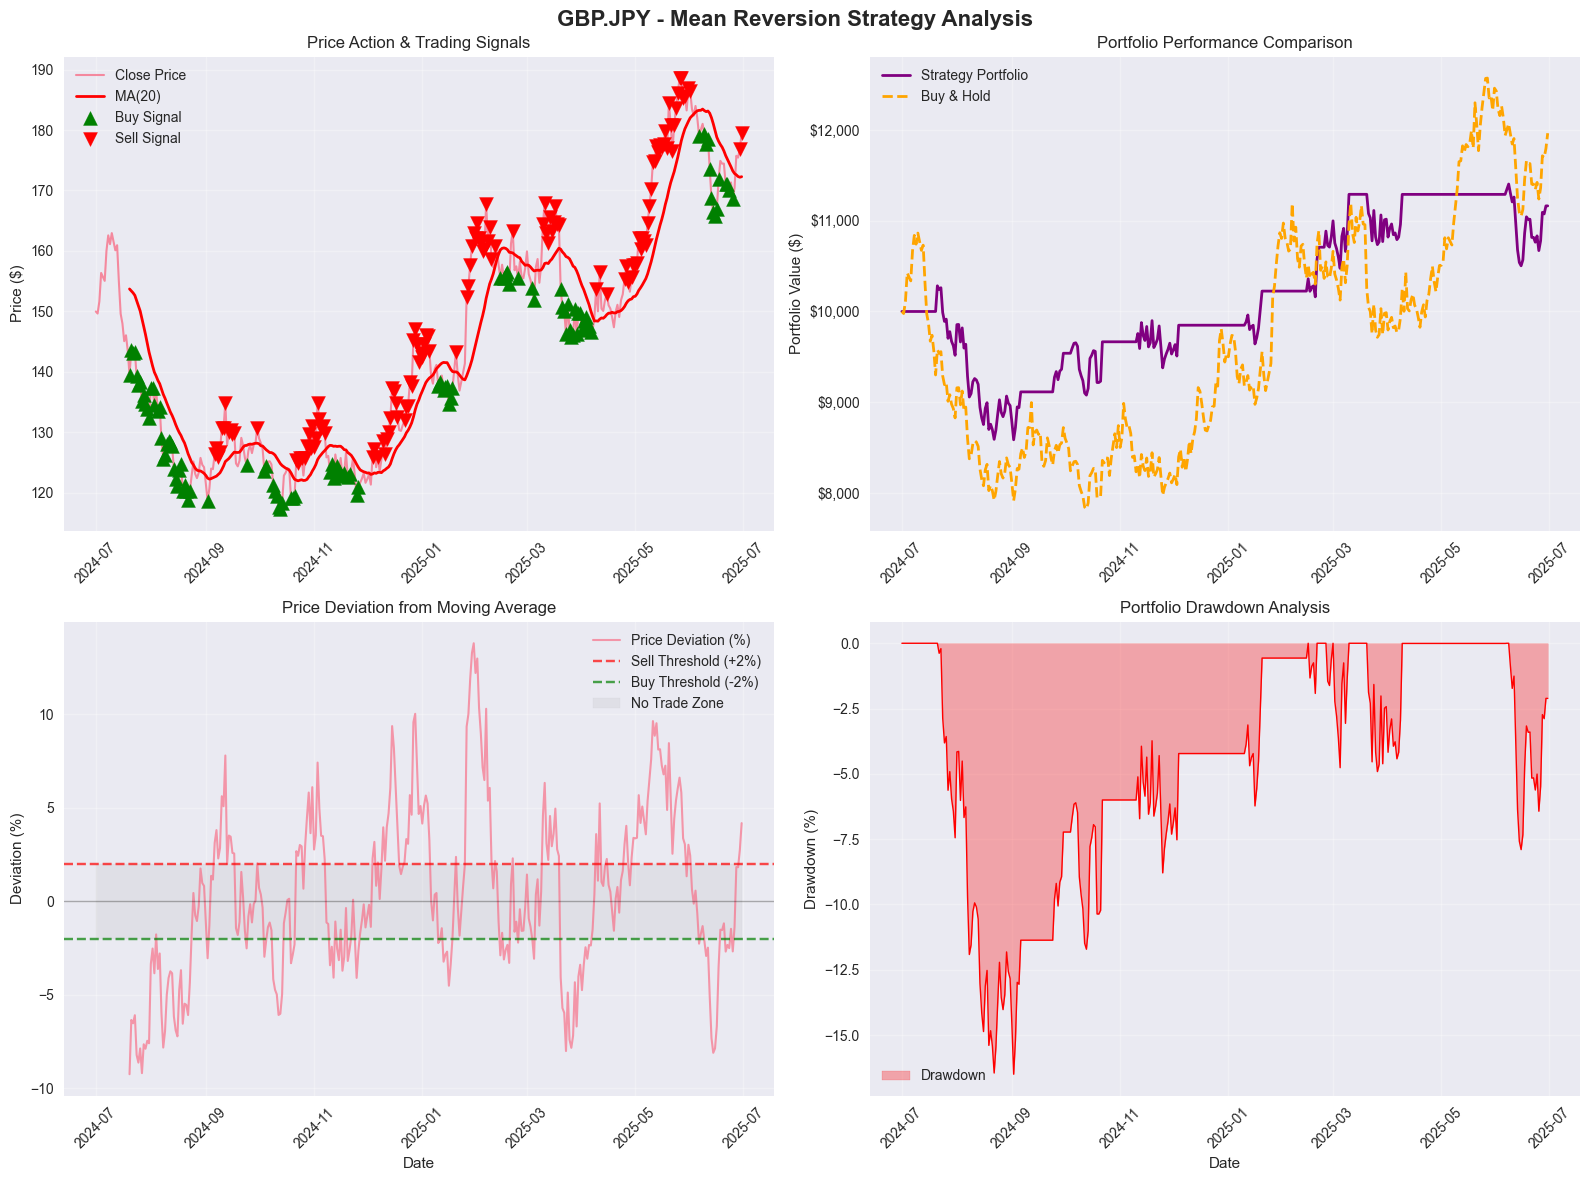


📊 ADDITIONAL ANALYSIS: RETURNS DISTRIBUTION
------------------------------


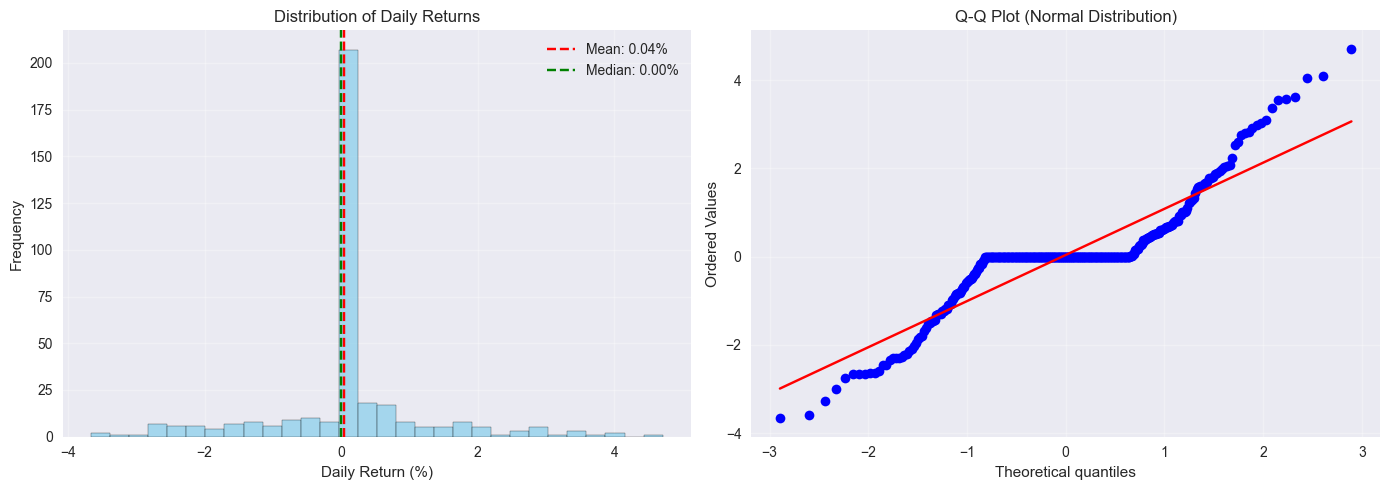

📊 Daily Returns Statistics:
   Mean:       0.037%
   Std Dev:    1.147%
   Skewness:   0.367
   Kurtosis:   3.088


In [19]:
# Configuration
SYMBOL = "GBP.JPY"
LOOKBACK_PERIOD = 20
ENTRY_THRESHOLD = 0.02
INITIAL_CAPITAL = 10000
DAYS_OF_DATA = 365

print("🚀 QUANTITATIVE TRADING STRATEGY ANALYSIS")
print("=" * 60)
print(f"Symbol: {SYMBOL}")
print(f"Strategy: Mean Reversion")
print(f"Lookback Period: {LOOKBACK_PERIOD} days")
print(f"Entry Threshold: ±{ENTRY_THRESHOLD:.1%}")
print(f"Initial Capital: ${INITIAL_CAPITAL:,}")
print("=" * 60)

# Step 1: Get Data
print("\n📊 STEP 1: DATA COLLECTION")
print("-" * 30)

# Try to get real data from IB API first
df = get_historical_data(SYMBOL, days=DAYS_OF_DATA)

# If IB API fails, use sample data
if df is None:
    print("🎲 Using sample data for demonstration...")
    df = generate_sample_data(SYMBOL, days=DAYS_OF_DATA)

# Display data summary
print(f"\n📈 Data Summary:")
print(f"   Period: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"   Total Days: {len(df)}")
print(f"   Price Range: ${df['close'].min():.2f} - ${df['close'].max():.2f}")
print(f"   Average Volume: {df['volume'].mean():,.0f}")

# Show first few rows
print(f"\n📋 First 5 rows of data:")
display(df.head())

# Step 2: Initialize and Run Strategy
print("\n⚙️ STEP 2: STRATEGY EXECUTION")
print("-" * 30)

# Initialize strategy
strategy = MeanReversionStrategy(
    lookback_period=LOOKBACK_PERIOD, 
    entry_threshold=ENTRY_THRESHOLD
)

# Run backtest
df_result, trades, final_capital = strategy.backtest(df, initial_capital=INITIAL_CAPITAL)

print(f"✅ Strategy execution completed!")

# Step 3: Performance Analysis
print("\n📊 STEP 3: PERFORMANCE ANALYSIS")
print("-" * 30)

# Analyze performance
performance_metrics = analyze_performance(df_result, trades, final_capital, INITIAL_CAPITAL)

# Display trade log
display_trade_log(trades, max_trades=10)

# Step 4: Visualizations
print("\n📈 STEP 4: VISUALIZATION")
print("-" * 30)

# Plot main strategy results
plot_strategy_results(df_result, trades, SYMBOL)

# Additional Analysis: Returns Distribution
print("\n📊 ADDITIONAL ANALYSIS: RETURNS DISTRIBUTION")
print("-" * 30)

plot_returns_distribution(df_result)